In [1]:
from scipy.io import loadmat
import numpy as np
import pickle
import pandas as pd

from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, LSTM, Embedding, Permute

from tensorflow.keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import keras
import mne
import matplotlib.pyplot as plt
import os
from keras.callbacks import LearningRateScheduler

import keras.backend as K
import math

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
print(keras.__version__)

2.5.0


# 1 数据读取

In [6]:
##################################################################
# @param  path
# @return  Xtrain, Xtest, ytrain, ytest
# @desc  输入LSTM要求的X的格式(slice_num, time_step, vector_num)     slice_num * time_step = totalAmount
##################################################################
def loadData(path,fs = 128):
    with open(path, 'rb') as f: 
        data = pickle.load(f)
    x1 = data['trial_1']['focussed']
    x2 = data['trial_1']['unfocussed']
    x3 = data['trial_1']['drowsed']
    for i in range(2,6):
        x1 = np.concatenate((x1,data[f'trial_{i}']['focussed']),axis=0)
        x2 = np.concatenate((x2,data[f'trial_{i}']['unfocussed']),axis=0)
        x3 = np.concatenate((x3,data[f'trial_{i}']['drowsed']),axis=0)
    size = len(x1)
    X = np.concatenate((x1,x2,x3),axis=0)
    y = np.concatenate((np.array([2 for _ in range(size)], dtype = int),
                        np.array([1 for _ in range(size)], dtype = int),
                        np.array([0 for _ in range(size)], dtype = int))
                      )
    y = y.reshape(len(y),1)
    y = np_utils.to_categorical(y, 3).astype('int8')

    per = np.random.permutation(X.shape[0]) #打乱后的行号
    X = X[per, :, :] #获取打乱后的训练数据
    y = y[per]
    
    # CNN
    X = X.reshape(np.shape(X)[0], np.shape(X)[1], np.shape(X)[2],1)
    
#     '''用于SVM'''
#     X =  X.reshape(np.shape(X)[0],np.shape(X)[1]*np.shape(X)[2])
#     y = y.reshape(len(y))
    
    # 分割训练集，测试集
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=33)
    return Xtrain, ytrain, Xtest, ytest
#     return X, y

# 2 模型搭建

### 2.1 LSTM

In [1]:
##################################################################
# @param  input_shape: (time_step, vector)
# @return  model
##################################################################
def DoubleLSTM(input_shape):
    TIME_STEPS = input_shape[0]
    INPUT_DIM = input_shape[1]
    layer1_units = 768
    layer2_units = 256
    
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,)) 
    
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    lstm_out_1 = LSTM(layer1_units, return_sequences=True)(inputs)
    
    # 注意力机制
    # attention_mul = attention_3d_block(lstm_out_1, input_shape[0])
    
    
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    lstm_out_2 = LSTM(layer2_units, return_sequences=False)(lstm_out_1)
    #lstm_out_2 = Flatten()(lstm_out_2)
    
    outputs = Dense(3, activation='sigmoid')(lstm_out_2)
    model = Model(inputs=inputs, outputs=outputs)
    
    #查看网络结构
    model.summary()
    
    #编译模型
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


In [5]:
DoubleLSTM(np.array([10,10]))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### 2.2 CNN

In [16]:
from keras.layers import MaxPooling2D,Conv2D,Flatten,Dense, Dropout
from keras.models import Sequential

In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD

from keras import backend as K

def CNN(input_shape):
    # backup/trail_1/
    # building model
    K.set_image_data_format('channels_last')
    model = Sequential()

    # adding layers
    model.add(Conv2D(64, (2, 2), padding="same",input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(128, (2, 2),padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
#     model.add(Dropout(0.3))
#     model.add(Conv2D(256, (2, 2),padding="same", activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    # 全连接层
    model.add(Dense(128, activation='relu',name='FC1'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu',name='FC2'))
    model.add(Dropout(0.2))

    # prediction layer, using softmax because we are expecting more than two outcomes (DROWSY, FOCUSED, UNFOCUSED)
    model.add(Dense(3, activation='softmax'))
    
    model.summary()
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [18]:
def new_CNN(input_shape):
    # backup/trail_1/
    # building model
    K.set_image_data_format('channels_last')
    model = Sequential()

    # adding layers
    model.add(Conv2D(64, (1, 1), padding="same",input_shape=input_shape, activation='relu'))
    model.add(Flatten())
    
    # 全连接层
    model.add(Dense(256, activation='relu',name='FC1'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu',name='FC2'))

    # prediction layer, using softmax because we are expecting more than two outcomes (DROWSY, FOCUSED, UNFOCUSED)
    model.add(Dense(3, activation='softmax'))
    
    model.summary()
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return model

### 2.3 SVM

In [8]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem # sem 标准误差平均
from sklearn import svm
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)             # 训练
    
    print ("训练集精度:")   # 训练集精度
    print (clf.score(X_train, y_train))

    print ("\n测试集精度:")    # 测试集精度
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("\n分类识别报告:")      # 分类识别报告
    print (metrics.classification_report(y_test, y_pred))

    print ("\n混淆矩阵:")           # 混淆矩阵
    print (metrics.confusion_matrix(y_test, y_pred))


def evaluate_cross_validation(clf, X, y, K):
    # 创建 K-折交叉验证迭代器对象
    cv = KFold(K, shuffle=True, random_state=0)
    #cv = KFold(len(y), K, shuffle=True, random_state=0)
    # 计算返回分数
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (("\n平均值: {0:.3f} (均标准差:+/-{1:.3f})").
           format(
               np.mean(scores), # 均值
               sem(scores) )    # 均标准差
           )

#-----------------------------#
# 用SVM来搭建预测模型
#-----------------------------#
clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 2.5,gamma=0.07,max_iter=6000,tol=0.001,probability=True)

In [9]:
path = '../../EEG Data/Disposed/subject_1.pkl'
# X_train,y_train,X_test, y_test = loadData(path)
X_train, y_train, X_test, y_test = loadData(path)

In [10]:
np.shape(X_train)

(3672, 7, 79, 1)

In [20]:
print("6折交叉验证结果：")
X,y = loadData(path)
clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 5,gamma=0.3,max_iter=3000,tol=0.001,probability=True)
evaluate_cross_validation(clf, X, y, 6)

6折交叉验证结果：


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_ite

[0.97777778 0.96944444 0.96388889 0.9625     0.98055556 0.97777778]

平均值: 0.972 (均标准差:+/-0.003)


In [16]:
clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 5,gamma=0.3,max_iter=1000,tol=0.01,probability=True)
train_and_evaluate(clf, X_train, X_test, y_train, y_test)

D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


训练集精度:
1.0

测试集精度:
0.9675925925925926

分类识别报告:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       217
           1       0.98      0.96      0.97       215
           2       0.95      0.98      0.96       216

    accuracy                           0.97       648
   macro avg       0.97      0.97      0.97       648
weighted avg       0.97      0.97      0.97       648


混淆矩阵:
[[210   2   5]
 [  3 206   6]
 [  2   3 211]]


In [11]:
clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 5,gamma=0.3,max_iter=2000,tol=0.01,probability=True)
train_and_evaluate(clf, X_train, X_test, y_train, y_test)

训练集精度:
1.0

测试集精度:
0.9722222222222222

分类识别报告:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       217
           1       0.98      0.96      0.97       215
           2       0.96      0.97      0.97       216

    accuracy                           0.97       648
   macro avg       0.97      0.97      0.97       648
weighted avg       0.97      0.97      0.97       648


混淆矩阵:
[[213   1   3]
 [  3 207   5]
 [  2   4 210]]


In [21]:
# 网格搜索
from sklearn.model_selection  import GridSearchCV

C_list = np.array([5,10,20])   #np.arange(1,5,1.5)
gamma_list = np.array([0.3,1,5])  #np.arange(0.05,0.15,0.02)
parameters = {
   'gamma': gamma_list,
   'C': C_list
}
print("svc__gamma参数取值："+str(gamma_list))
print("svc__C参数取值："+str(C_list))

clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 5,gamma=0.3,max_iter=3000,tol=0.001,probability=True)
gs = GridSearchCV(clf, parameters, verbose=2, refit=False, cv=3)
%time _ = gs.fit(X, y)
gs.best_params_, gs.best_score_

svc__gamma参数取值：[0.3 1.  5. ]
svc__C参数取值：[ 5 10 20]
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=5, gamma=0.3 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=0.3, total=  38.7s
[CV] C=5, gamma=0.3 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s remaining:    0.0s
D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=0.3, total=  36.5s
[CV] C=5, gamma=0.3 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=0.3, total=  37.4s
[CV] C=5, gamma=1.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=1.0, total=  38.2s
[CV] C=5, gamma=1.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=1.0, total=  38.5s
[CV] C=5, gamma=1.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=1.0, total=  37.9s
[CV] C=5, gamma=5.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=5.0, total=  37.2s
[CV] C=5, gamma=5.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=5.0, total=  39.6s
[CV] C=5, gamma=5.0 ..................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] ................................... C=5, gamma=5.0, total=  37.6s
[CV] C=10, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=0.3, total=  35.6s
[CV] C=10, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=0.3, total=  37.7s
[CV] C=10, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=0.3, total=  37.0s
[CV] C=10, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=1.0, total=  40.5s
[CV] C=10, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=1.0, total=  36.1s
[CV] C=10, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=1.0, total=  38.2s
[CV] C=10, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=5.0, total=  41.5s
[CV] C=10, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=5.0, total=  36.5s
[CV] C=10, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=10, gamma=5.0, total=  35.0s
[CV] C=20, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=0.3, total=  33.8s
[CV] C=20, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=0.3, total=  34.3s
[CV] C=20, gamma=0.3 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=0.3, total=  34.1s
[CV] C=20, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=1.0, total=  35.2s
[CV] C=20, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=1.0, total=  35.7s
[CV] C=20, gamma=1.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=1.0, total=  37.8s
[CV] C=20, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=5.0, total=  37.7s
[CV] C=20, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=5.0, total=  38.2s
[CV] C=20, gamma=5.0 .................................................


D:\Apps\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................................. C=20, gamma=5.0, total=  36.2s
Wall time: 16min 42s


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 16.7min finished


({'C': 5, 'gamma': 0.3}, 0.955787037037037)

# 3 可视化

In [12]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_accuracy = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure(figsize=(13,8))
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_accuracy[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type,fontsize=20)
        plt.ylabel('acc-loss',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc="upper right",fontsize=15)
        plt.show()

# 4 附件

### 4.1 学习率调整

In [13]:
def scheduler(epoch):
    # 每隔100个epoch，学习率减小为原来的1/2
    if epoch == 0:
        K.set_value(model.optimizer.lr, 4e-4)
    if epoch % 30 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
        print("lr changed to {}".format(lr * 0.5))
    return K.get_value(model.optimizer.lr)

### 4.2 注意力机制

In [14]:
def attention_3d_block(inputs, TIME_STEPS):
    # inputs.shape = (batch_size, time_steps, lstm_units)
    # (batch_size, time_steps, lstm_units) -> (batch_size, lstm_units, time_steps)
    a = Permute((2, 1))(inputs)

    # 对最后一维进行全连接
    # (batch_size, lstm_units, time_steps) -> (batch_size, lstm_units, time_steps)
    a = Dense(TIME_STEPS, activation='softmax')(a)

    # (batch_size, lstm_units, time_steps) -> (batch_size, time_steps, lstm_units)
    a_probs = Permute((2, 1), name='attention_vec')(a)

    # 相乘
    # 相当于获得每一个step中，每个维度在所有step中的权重
    output_attention_mul = concatenate([inputs, a_probs], axis=1)
    return output_attention_mul

### 4.3 生成器
 - 可以自定义处理train和val的数据
 - 数据量很大时，可以用此方法分块从磁盘读取

In [34]:
def xs_gen(data_X,data_y,steps, batch_size = 210,train=True):
    
    per = np.random.permutation(data_X.shape[0]) #打乱后的行号
    data_X = data_X[per, :, :] #获取打乱后的训练数据
    data_y = data_y[per]
    
    split_size = int(0.15*len(data_X))
    
    if train:
        data_X = data_X[split_size:]
        data_y = data_y[split_size:]
    else:
        data_X = data_X[:split_size]
        data_y = data_y[:split_size]
    while True:
        for i in range(steps):
            batch_X = data_X[i * batch_size : i * batch_size + batch_size]
            batch_y = data_y[i * batch_size : i * batch_size + batch_size]
            yield batch_X, batch_y

# 5 训练

### 5.1 常规训练 ( .fit() )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 79)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 768)            2605056   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 3,655,427
Trainable params: 3,655,427
Non-trainable params: 0
_________________________________________________________________
Train on 714 samples, validate on 126 samples
Epoch 1/100
714/714 [==============================] - 1s 2ms/sample - loss: 1.1016 - accuracy: 0.3221 - val_loss: 1.0882 - val_accuracy: 0.3889
Epoch 2/100
714/714 [==============================] - 1

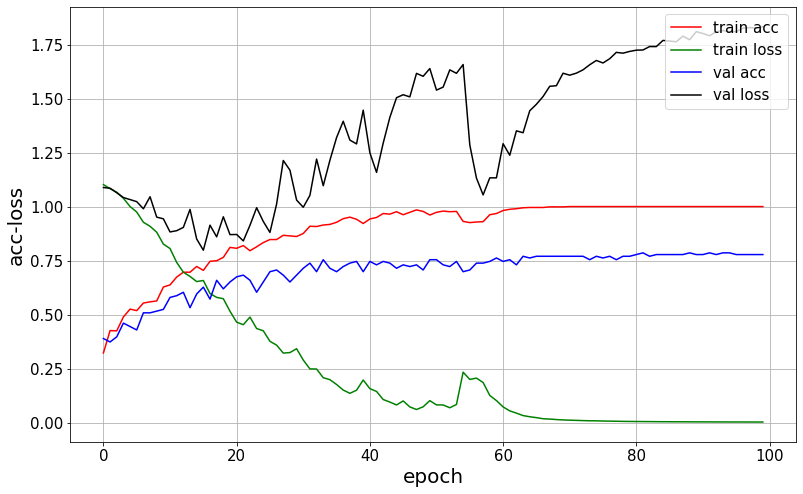

In [13]:
history = LossHistory()
path = '../../EEG Data/Disposed/subject_1.pkl'
X,y,X_test, y_test = loadData(path)
input_shape = np.shape(X)[1:]
model = DoubleLSTM(input_shape)
lr_new = LearningRateScheduler(scheduler)

size = np.shape(X)[0]
steps = 6
batch_size = size // steps

model.fit(X, y,
            batch_size=batch_size, epochs=100,
            verbose=1,
            validation_data=(X_test, y_test),
            #validation_split=0.15,
            shuffle = True,
            callbacks=[lr_new, history])

history.loss_plot('epoch')

### 5.2 训练CNN

In [ ]:
history = LossHistory()
path = '../../EEG Data/Disposed/subject_1.pkl'
X,y,X_test, y_test = loadData(path)
input_shape = np.shape(X)[1:]
model = CNN(input_shape)
lr_new = LearningRateScheduler(scheduler)

size = np.shape(X)[0]
steps = 10
batch_size = size // steps

model.fit(X, y,
            batch_size=batch_size, epochs=100,
            verbose=1,
            validation_data=(X_test, y_test),
            #validation_split=0.15,
            shuffle = True,
            callbacks=[lr_new,history])

history.loss_plot('epoch')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 79, 64)         320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 39, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 39, 128)        32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 19, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 17024)             0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               2179200   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

D:\Apps\Anaconda3\lib\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3672/3672 [==============================] - 2s 502us/sample - loss: 1.0337 - accuracy: 0.4638 - val_loss: 1.0192 - val_accuracy: 0.4475
Epoch 3/100
3672/3672 [==============================] - 2s 504us/sample - loss: 1.0119 - accuracy: 0.4807 - val_loss: 0.9862 - val_accuracy: 0.5478
Epoch 4/100
3672/3672 [==============================] - 2s 650us/sample - loss: 0.9797 - accuracy: 0.5218 - val_loss: 0.9596 - val_accuracy: 0.5278
Epoch 5/100
1835/3672 [=============>................] - ETA: 1s - loss: 0.9700 - accuracy: 0.5302

In [31]:
# CNN+SVM

# 获取全连接层的输出

FC_output = Model(inputs=model.input,outputs=model.get_layer('FC2').output)

In [45]:
X_tmp = FC_output.predict(X)
X_test_tmp = FC_output.predict(X_test)
y_tmp = np.array([np.argmax(i) for i in y])
y_test_tmp = np.array([np.argmax(i) for i in y_test])

In [50]:
clf = svm.SVC(kernel= 'rbf',class_weight='balanced',C = 2.5,gamma=0.07,max_iter=6000,tol=0.001,probability=True)
train_and_evaluate(clf, X_tmp, X_test_tmp, y_tmp, y_test_tmp)

训练集精度:
1.0

测试集精度:
0.7936507936507936

分类识别报告:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        42
           1       0.82      0.77      0.80        53
           2       0.64      0.81      0.71        31

    accuracy                           0.79       126
   macro avg       0.79      0.80      0.79       126
weighted avg       0.81      0.79      0.80       126


混淆矩阵:
[[34  3  5]
 [ 3 41  9]
 [ 0  6 25]]


### 5.2 生成器方法训练 ( .fit_generator() )

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 7, 600)            1632000   
_________________________________________________________________
lstm_65 (LSTM)               (None, 300)               1081200   
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 903       
Total params: 2,714,103
Trainable params: 2,714,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 4s 336ms/step - loss: 1.0988 - accuracy: 0.3656 - val_loss: 1.0860 - val_accuracy: 0.4200
Epoch 2/100
4/4 [==============================] - 0s 119ms/step - loss: 1.0835 - accuracy: 0.4273 - val_loss: 1.0733 - val_accuracy: 0.4200
Epoch 3/100
4/4 [==============================] - 0s 116ms/step - loss: 1.0689 - accuracy:

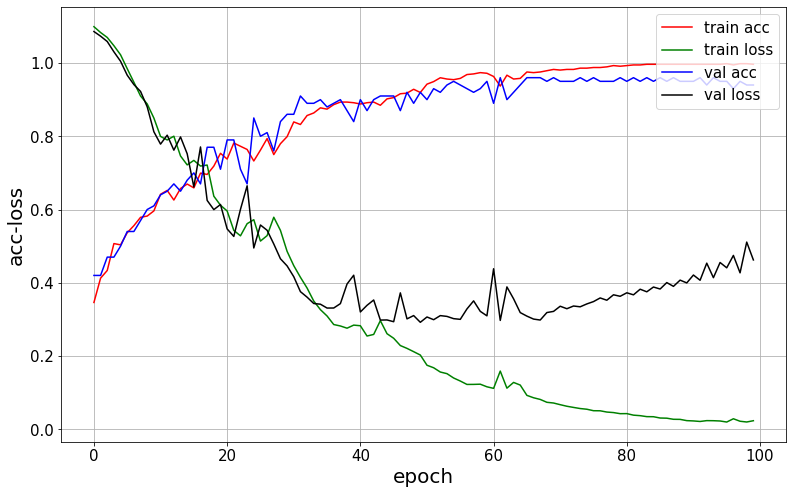

6/6 [==============================] - 1s 23ms/step - loss: 2.3782 - accuracy: 0.7381
Test score: 2.378248929977417
Test accuracy: 0.738095223903656


In [115]:
history = LossHistory()
path = '../../EEG Data/Disposed/subject_1.pkl'
X,y,X_test, y_test = loadData(path)
input_shape = np.shape(X)[1:]
model = DoubleLSTM(input_shape)
lr_new = LearningRateScheduler(scheduler)

Batch_size = 168
steps = 4
size = np.shape(X)[0]

train_iter = xs_gen(X,y,steps,batch_size=Batch_size, train=True)
test_iter = xs_gen(X,y,steps,batch_size=Batch_size, train=False)


# model.fit(X, y,
#             batch_size=210, epochs=100,
#             verbose=1,
#             validation_split=0.15,
#             shuffle = True,
#             callbacks=[lr_new, history])




model.fit_generator(
        generator=train_iter,
        steps_per_epoch=steps,
        epochs=100,
        initial_epoch=0,
        validation_data = test_iter,
        validation_steps = steps,
        callbacks=[lr_new, history]
        )

#绘制acc-loss曲线
history.loss_plot('epoch')

#模型评估
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


In [ ]:
if __name__ == '__main__':
    # 如果没有cuda加速，取消注释
    #os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
    #os.environ["CUDA_VISIBLE_DEVICES"] = ""

    # 导入数据
    path = '../../EEG Data/Disposed/subject_2.pkl'
    X_train, X_test, y_train, y_test = loadData(path, seconds = 2)

    print("X_train维度：" + str(np.shape(X_train)))
    print("y_train维度：" + str(np.shape(y_train)))
    print("X_test维度：" + str(np.shape(X_test)))
    print("y_test维度：" + str(np.shape(y_test)))
    input_shape = np.shape(X_train)[1:]
    model = DoubleLSTM(input_shape)
    model.fit(X_train, y_train, epochs=50, batch_size=306)

    score, acc = model.evaluate(X_test, y_test,
                                batch_size=90)
    print('loss分数:', score)
    print('测试精度:', acc)
    
    
    
    
    
    
    #迭代训练（注意这个地方要加入callbacks）
    model.fit(X_train, Y_train,
            batch_size=batch_size, epochs=50,
            verbose=1, 
            validation_data=(X_test, Y_test),
            callbacks=[history])
#模型评估
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

#绘制acc-loss曲线
history.loss_plot('epoch')

In [ ]:
# (slice_num, time_step, vector_num)     slice_num * time_step = totalAmount